In [1]:
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
from dataclasses import dataclass
import random
import math

In [2]:
random.choice([1,2,3,4,5])

3

In [3]:
convo = Path('jim_marcus.txt').read_text()
clean_lines = []
for line in convo.split('\n')[1:]:

    if not isinstance(line, str):
        print(line)
        continue

    
    if 'Jim Barrett:' in line:
        clean_line = line.split('Jim Barrett:')[-1]
    elif 'Marcus Näslund:' in line:
        clean_line = line.split('Marcus Näslund:')[-1]
    else:
        clean_line = line
    
    if 'media omitted' in clean_line.lower():
        continue
    
    clean_lines.append(clean_line)

all_words = []
for line in clean_lines:
    all_words += list(map(lambda x: x.lower(), line.split()))

counts = Counter(all_words)
total_words = len(all_words)
word_to_freq = {word: count/total_words for word, count in counts.items()}

In [4]:
FONT_PATH = Path("/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf")


In [5]:
@dataclass
class Rectangle:

    width: float
    
    height: float
    x: float
    y: float


In [6]:
def find_fontsize_for_width(width, word):
    # TODO: optmisie by early breaking/binary search etc

    min_diff_w = 1000000
    best_font_size = None
    for fontsize in range(1, 100, 1):
        font = ImageFont.truetype(FONT_PATH, fontsize)
        length = font.getlength(word)
        diff_w = width - length
        if diff_w < min_diff_w:
            min_diff_w = diff_w
            best_font_size = fontsize


    return best_font_size
        


In [7]:
def get_first_rectangle(first_word, canvas_dims=Rectangle(500,500, 0, 0)):
    first_word_width = 0.6 * canvas_dims.width
    font_size = find_fontsize_for_width(first_word_width, first_word)

    left_edge_pos = 0.2*canvas_dims.width
    top_edge_pos = (canvas_dims.height - font_size) / 2 

    first_rectangle = Rectangle(width=first_word_width, height=font_size, x=left_edge_pos, y=top_edge_pos)

    return first_rectangle
    

In [8]:
def get_initial_available_rectangles_from_first_rectangle(first_rectangle, canvas_dims=Rectangle(500,500, 0, 0)):

    initial_rectangles = [
        Rectangle(width=canvas_dims.width, height=first_rectangle.y, x=0, y=0),
        Rectangle(width=first_rectangle.x, height=first_rectangle.height, x=0, y=first_rectangle.y),
        Rectangle(width=first_rectangle.x, height=first_rectangle.height, x=0.8*canvas_dims.width, y=first_rectangle.y),
        Rectangle(width=canvas_dims.width, height=first_rectangle.y, x=0, y=first_rectangle.y+first_rectangle.height)
    ]

    return initial_rectangles
    

In [9]:
def fill_remaining_space_vertical(outer_rect: Rectangle, inner_rect: Rectangle) -> list[Rectangle]:
    """
    Returns a list of rectangles that fill the remaining space between the outer and inner rectangles.

    Args:
        outer_rect (Rectangle): Outer rectangle.
        inner_rect (Rectangle): Inner rectangle.

    Returns:
        list[Rectangle]: List of rectangles that fill the remaining space.
    """
    # Calculate the remaining space
    remaining_width = outer_rect.width - inner_rect.width
    remaining_height = outer_rect.height - inner_rect.height

    # Calculate the x and y offsets for the inner rectangle
    inner_x_offset = inner_rect.x - outer_rect.x
    inner_y_offset = inner_rect.y - outer_rect.y

    # Create a list to store the rectangles that fill the remaining space
    rectangles = []

    # Top rectangle
    if inner_y_offset > 0:
        rectangles.append(Rectangle(
            x=inner_rect.x,
            y=outer_rect.y,
            width=inner_rect.width,
            height=inner_y_offset
        ))

    # Bottom rectangle
    if remaining_height > 0:
        rectangles.append(Rectangle(
            x=inner_rect.x,
            y=inner_rect.y + inner_rect.height,
            width=inner_rect.width,
            height=outer_rect.height - inner_y_offset - inner_rect.height
        ))

    # Left rectangle
    if inner_x_offset > 0:
        rectangles.append(Rectangle(
            x=outer_rect.x,
            y=outer_rect.y,
            width=inner_x_offset,
            height=outer_rect.height
        ))

    # Right rectangle
    if remaining_width > 0:
        rectangles.append(Rectangle(
            x=inner_rect.x + inner_rect.width,
            y=outer_rect.y,
            width=outer_rect.width - inner_x_offset - inner_rect.width,
            height=outer_rect.height
        ))

    return rectangles


In [10]:
def fill_remaining_space_horizontal(outer_rect: Rectangle, inner_rect: Rectangle) -> list[Rectangle]:
    """
    Returns a list of rectangles that fill the remaining space between the outer and inner rectangles.

    Args:
        outer_rect (Rectangle): Outer rectangle.
        inner_rect (Rectangle): Inner rectangle.

    Returns:
        list[Rectangle]: List of rectangles that fill the remaining space.
    """
    # Calculate the remaining space
    remaining_width = outer_rect.width - inner_rect.width
    remaining_height = outer_rect.height - inner_rect.height

    # Calculate the x and y offsets for the inner rectangle
    inner_x_offset = inner_rect.x - outer_rect.x
    inner_y_offset = inner_rect.y - outer_rect.y

    # Create a list to store the rectangles that fill the remaining space
    rectangles = []

    # Top rectangle
    if inner_y_offset > 0:
        rectangles.append(Rectangle(
            x=outer_rect.x,
            y=outer_rect.y,
            width=outer_rect.width,
            height=inner_y_offset
        ))

    # Bottom rectangle
    if remaining_height > 0:
        rectangles.append(Rectangle(
            x=outer_rect.x,
            y=inner_rect.y + inner_rect.height,
            width=outer_rect.width,
            height=outer_rect.height - inner_y_offset - inner_rect.height
        ))

    # Left rectangle
    if inner_x_offset > 0:
        rectangles.append(Rectangle(
            x=outer_rect.x,
            y=inner_rect.y,
            width=inner_x_offset,
            height=inner_rect.height
        ))

    # Right rectangle
    if remaining_width > 0:
        rectangles.append(Rectangle(
            x=inner_rect.x + inner_rect.width,
            y=inner_rect.y,
            width=outer_rect.width - inner_x_offset - inner_rect.width,
            height=inner_rect.height
        ))

    return rectangles


In [11]:
def fill_next_word(word, required_font_size, available_rectangles, canvas):

    font = ImageFont.truetype(FONT_PATH, required_font_size)
    word_length = font.getlength(word)
    
    suitable_horizontal_rectangles = []
    for rectangle in available_rectangles:
        if rectangle.width < word_length:
            continue
        if rectangle.height < required_font_size:
            continue
        suitable_horizontal_rectangles.append(rectangle)

    suitable_vertical_rectangles = []
    for rectangle in available_rectangles:
        if rectangle.height < word_length:
            continue
        if rectangle.width < required_font_size:
            continue
        suitable_vertical_rectangles.append(rectangle)

    if len(suitable_rectangles) == 0:
        # print(f"skipping word '{word}', couldn't find a good rectangle")
        return available_rectangles

    match random.choice(['horizontal', 'vertical']):
        case 'horizontal':
            chosen_rectangle = max(suitable_rectangles, key=lambda x: x.height * x.width)

            text_rectangle = Rectangle(
                    x=random.uniform(chosen_rectangle.x, chosen_rectangle.x + chosen_rectangle.width - word_length), 
                    y=random.uniform(chosen_rectangle.y, chosen_rectangle.y + chosen_rectangle.height - required_font_size),
                    width=word_length,
                    height=required_font_size
                )
            
            # fill the word in
            canvas.text(
                (text_rectangle.x,
                text_rectangle.y), 
                word, 
                fill=(255, 255, 0), 
                font=font
            )
        case 'vertical':
            chosen_rectangle = max(suitable_vertical_rectangles, key=lambda x: x.height * x.width)

            text_rectangle = Rectangle(
                    x=random.uniform(chosen_rectangle.x, chosen_rectangle.x + chosen_rectangle.width - word_length), 
                    y=random.uniform(chosen_rectangle.y, chosen_rectangle.y + chosen_rectangle.height - required_font_size),
                    width=word_length,
                    height=required_font_size
                )
            
            # fill the word in
            canvas.text(
                (text_rectangle.x,
                text_rectangle.y), 
                word, 
                fill=(255, 255, 0), 
                font=font
            )

    # figure out new available rectangles
    fill_func = random.choice([fill_remaining_space_horizontal, fill_remaining_space_vertical])
    new_available_rectangles = fill_func(chosen_rectangle, text_rectangle)
                                                    

    # remove the chosen rectangle and add the new ones
    available_rectangles.remove(chosen_rectangle)
    return available_rectangles + new_available_rectangles
    

In [12]:
def draw_rectangle(canvas, rectangle):
    canvas.rectangle((rectangle.x, rectangle.y, rectangle.x+rectangle.width, rectangle.y+rectangle.height))

In [13]:
def make_word_cloud(all_words, canvas_dims=Rectangle(500,500, 0, 0)):

    # Create a new image
    img = Image.new('RGB', (canvas_dims.width, canvas_dims.height), color = (73, 109, 137))
    canvas = ImageDraw.Draw(img)
    
    word_counts = Counter(all_words)

    first_word, first_count = word_counts.most_common(1)[0]
    
    #initial_rectangle = get_first_rectangle(first_word, canvas_dims)

    # print the first word
    #initial_font = ImageFont.truetype(FONT_PATH, initial_rectangle.height)
    #canvas.text((initial_rectangle.x, initial_rectangle.y), first_word, fill=(255, 255, 0), font=font)
    #draw_rectangle(canvas, initial_rectangle)
    
    #available_rectangles = get_initial_available_rectangles_from_first_rectangle(initial_rectangle, canvas_dims)

    available_rectangles = [canvas_dims]
    initial_font_size = 100
    for i, (word, count) in enumerate(word_counts.most_common()):

        
        if i ==0:
            required_font_size = initial_font_size
        else:
            required_font_size = initial_font_size * math.sqrt(count/first_count)

        if required_font_size < 1:
            break
        
        available_rectangles = fill_next_word(word, required_font_size, available_rectangles, canvas)

    return img


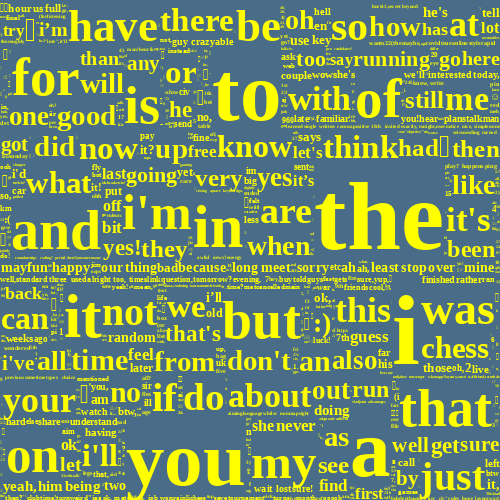

In [14]:
make_word_cloud(all_words)